In this notebook, SentenceTransformer is used to embed recommendation texts into vectors. Then AgglomerativeClustering is used to put similar recommendations into groups.

In [0]:
pip install -U sentence-transformers

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip install sacremoses

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
%run ./utilities/Data_Clean_Functions

In [0]:
%run ./utilities/utilities

In [0]:
import numpy as np
import pandas as pd
import spacy
import en_core_web_sm
import re
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sentence_transformers import SentenceTransformer
import pickle

In [0]:
# load recommendation lists
recommd = spark.sql('select * from NAII.CMV_Reports_Article_Recommendations_lists order by Year').toPandas()
recommd['RecommendLists'] = [i.split("&&") for i in recommd['Recommendations']]
print(recommd['RecommendLists'][0][:5])
# print(recommd.head())

['1. establish a separate budget line item for the advisory committee on minority veterans.', '2. appropriate 125,000.00 for the fiscal year year budget for the advisory committee on minority veterans.', '3. recognize the appropriate regional and national minority organizations that serve our country diverse population groups and invite them as genuine partners, consultants, advisors and expert witnesses in enriching the departments commitment to serve the needs of our minority veterans.', '4. authorize an assessment be conducted and a report submitted in by 97 by the department of veterans affairs to determine the validity of the committees concern regarding ethnic representation on the rating panels and the men review boards, as well as among the counselor who advise our minority veteran populations.', '5. establish and fund an intro agency task force, chaired by the director of the center for minority veterans, to conduct a needs assessment for health care, benefits and compensation

In [0]:
# check the number of recommendations and number of words in total
i = 0
j = 0
for red in recommd['RecommendLists']:
        i = i + len(red)
        for r in red:
#             if len(r.split(" ")) > 1143:
#                 print(r)
            j = j + len(r.split(" "))
        
print(i)
print(j)

259
11926


Use sentence encoders to embed recommendations into vectors. https://www.sbert.net/

In [0]:
# import tensorflow_hub as hub
# from sklearn.manifold import TSNE

# def embbedfn(text):
#     embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# #     strsent = list(nlp(text).sents)
# #     strsent =  [str(onesentence) for onesentence in strsent if len(onesentence)>10]
#     embeddings = embed(text)
# #     mapped_embeddings = TSNE(n_components=2, metric='cosine', init='pca', verbose = 1).fit_transform(embeddingslocal)
#     return embeddings

def embbedbert(text, model):
    embeddings = model.encode(text)
    return embeddings

model = SentenceTransformer('all-mpnet-base-v2')

In [0]:
# bert sentence encoder
recommd['embeddings'] = recommd.RecommendLists.apply(lambda x: embbedbert(x, model))
recommd['embeddings'][0].shape

Out[62]: (16, 768)

In [0]:
# unlist the nested lists
# previous structure -> [[recommd1 for 1996, recommd2 for 1996, ...], [recommd1 for 1997, recommd2 for 1997, ...],...]
# current structure -> [recommd1 for 1996, recommd2 for 1996, ..., recommd1 for 1997, recommd2 for 1997, ...]
embeddings = []
for i in recommd['embeddings']:
    embeddings.extend(i)
RecommendLists = []
for i in recommd['RecommendLists']:
    RecommendLists.extend(i)
    
print(len(embeddings))
print(len(RecommendLists))

259
259


In [0]:
Years = []
for i in range(len(recommd['RecommendLists'])):
    Years.extend(list(np.repeat(recommd['Year'][i], len(recommd['RecommendLists'][i]))))
print(len(Years))

259


In [0]:
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
# davies_bouldin_score: ratio of within-cluster distances to between-cluster distances
# clusters which are farther apart and less dispersed will result in a better score.

Start parameter tuning for classification. There are many metrics used here for measuring classification performance. 
1. davies_bouldin_score: ratio of within-cluster distances to between-cluster distances. 
2. silhouette_score: The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.
3. calinski_harabasz_score: It is also known as the Variance Ratio Criterion. Ratio of the sum of between-cluster dispersion and of within-cluster dispersion.

In [0]:
# parameter tunings
# final output is a dataframe that stores all the parameters and their corresponding classification scores

def agg_cluster_tuning(grid):
    output = {'affinity': [],
             'linkage': [],
              'distance_threshold': [],
             'silhouette_score': [],
             'calinski_harabasz_score': [],
             'davies_bouldin_score': [],
             'number_of_clusters': []}
    for aff in grid['affinity']:
        for link in grid['linkage']:
            try: 
                clusterer = AgglomerativeClustering(n_clusters=None, affinity=aff, linkage=link, distance_threshold=0.2)
                clusterer.fit_predict(embeddings)
                dist = clusterer.distances_
                minD = min(dist)
                maxD = max(dist)
                step = (max(dist)-min(dist))/10
                for d in np.arange(minD+step, maxD, step):
    #                 print(d)
                    # fit
                    clusterer = AgglomerativeClustering(n_clusters=None, affinity=aff, linkage=link, distance_threshold=d)
                    clusters = clusterer.fit_predict(embeddings)
                    output['affinity'].append(aff)
                    output['linkage'].append(link)
                    output['silhouette_score'].append(metrics.silhouette_score(embeddings, clusters, metric='euclidean'))
                    output['calinski_harabasz_score'].append(metrics.calinski_harabasz_score(embeddings, clusters))
                    output['davies_bouldin_score'].append(davies_bouldin_score(embeddings, clusters))
                    output['distance_threshold'].append(d)
                    output['number_of_clusters'].append(max(clusters)+1)

            except:
                   pass
    return output
         

In [0]:
grid = {'affinity': ['euclidean', 'manhattan', 'l1', 'l2', 'cosine'],
           'linkage': ['ward', 'complete', 'average', 'single']}
# get the output dataframe 
output = pd.DataFrame(agg_cluster_tuning(grid))

In [0]:
import datetime as dt
batch = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
batch 
output['batch'] = batch 
display(output)

affinity,linkage,distance_threshold,silhouette_score,calinski_harabasz_score,davies_bouldin_score,number_of_clusters,batch
euclidean,ward,0.522819964686148,0.081458,8.909780224381967,0.29861435674081016,239,20221101_215545
euclidean,ward,0.8696565304657948,0.13118882,3.369404163782129,0.9542508600590298,136,20221101_215545
euclidean,ward,1.2164930962454417,0.07941735,4.060183934043951,1.9802773052296285,45,20221101_215545
euclidean,ward,1.5633296620250885,0.05111963,5.103637178578343,2.6697664244857413,20,20221101_215545
euclidean,ward,1.9101662278047353,0.0303968,5.804964588325362,3.2051865402684006,12,20221101_215545
euclidean,ward,2.257002793584382,0.036869247,8.131639254918129,3.882162303293887,4,20221101_215545
euclidean,ward,2.603839359364029,0.02940096,12.747988527376576,4.09899813669416,2,20221101_215545
euclidean,ward,2.950675925143676,0.02940096,12.747988527376576,4.09899813669416,2,20221101_215545
euclidean,ward,3.2975124909233227,0.02940096,12.747988527376576,4.09899813669416,2,20221101_215545
euclidean,complete,0.2940685685018056,0.02660406,20.965222886211052,0.13763558042434038,254,20221101_215545


In [0]:
# save output
with open('/dbfs/NAII/CMV Reports/recommendation_parameter_tuning', 'wb') as fp:
    pickle.dump(output, fp)
# with open('/dbfs/NAII/CMV Reports/recommendation_parameter_tuning', 'rb') as fp:
#     output = pickle.load(fp)

In [0]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In sum, calinski harabasz score and the number of clusters were used to make the final decision on the values for the parameters. I chose one combination that will have relative good calinski_harabasz_score and reasonable number of clusters. silhouette_score and davies_bouldin_score are used to provide extra informantion on the classification performance.

In [0]:
clusterer = AgglomerativeClustering(n_clusters=None, affinity="euclidean", linkage="ward", distance_threshold = 1.25)
clusters = clusterer.fit_predict(embeddings)

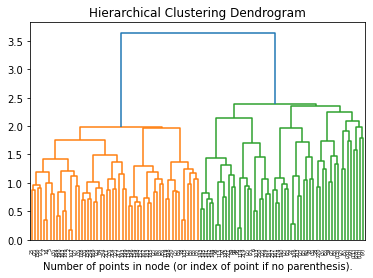

In [0]:
# plot hierarchical clustering dendrogram
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(clusterer, truncate_mode='level', p=6)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [0]:
# save output to delta lake
output_spark=spark.createDataFrame(output) 
write_to_delta(output_spark, 'NAII.CMV_Reports_Article_Recommendations_clusters')
# append_to_delta(output_spark, 'NAII.CMV_Reports_Article_Recommendations_clusters')

In [0]:
# plot of clusters in 2D
from sklearn.manifold import TSNE
from collections import Counter
mapped_embeddings = TSNE(n_components=2, metric='euclidean', init='pca').fit_transform(embeddings)

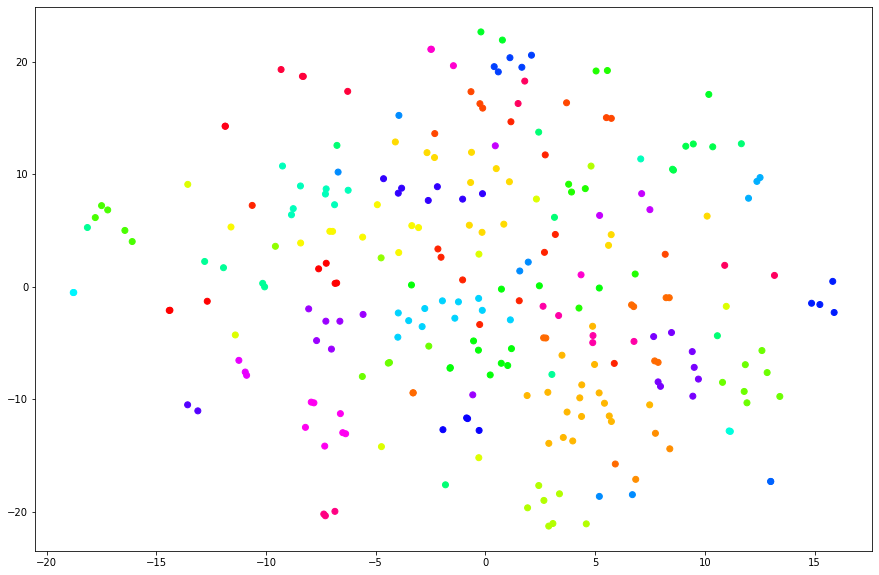

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
ax.scatter(x, y, c = clusters, cmap = 'hsv')
# ax.legend(clusters, title='clusters')
plt.show()

In [0]:
# present the distribution of clusters: number of recommendations in each cluster
display(pd.DataFrame({'cluster': [i for (i,j) in Counter(clusters).most_common()], 'freq': [j for (i,j) in Counter(clusters).most_common()]}))

cluster,freq
5,17
6,13
14,12
3,11
1,11
22,11
11,11
19,9
7,9
2,8


In [0]:
# create the output table with 3 columns: recommendation text, clusters and years
recommd_cluster = pd.DataFrame({"text": RecommendLists, "cluster": clusters, 'Years': Years})
display(recommd_cluster.loc[recommd_cluster['cluster'] == 5])

text,cluster,Years
"4. authorize an assessment be conducted and a report submitted in by 97 by the department of veterans affairs to determine the validity of the committees concern regarding ethnic representation on the rating panels and the men review boards, as well as among the counselor who advise our minority veteran populations.",5,1996
52. initiate a system to collect on going statistical data on minority veterans who are treated as inpatients on the va psychiatric wards at triple army medical center.,5,1997
"recommendation 4 there is a perception, from the meeting in new orleans, of unfair ratings of minority veterans compared to whites. the va regional office is aware of this claim and is looking into the matter.",5,2004
"recommendation 7 va expeditiously complies with the va acting general counsel opinion, subject webcams 372917 collection of veterans ethnic and racial demographic data, datedmonth2, year.",5,2007
"recommendation 15 the secretary directs vha, vba, and inca to collect demographic data throughout the va, in accordance, with the va acting general counsel opinion, subject webcams 372917 collection of veterans ethnic and racial demographic data, datedmonth2, year, and inform the acmv, on the status of the demographic data collection, by the next acme meeting in washington, dc.",5,2008
"recommendation 17 that the department of veterans affairs expeditiously implements the va acting general counsel opinion opinion , datedmonth2, year, which requires the va to collect ethnic and racial demographic data, from the veteran population that it serves, by voluntary self identification.",5,2008
recommendation 18 via provide information that reflects if minority veterans are identified with having pts or other diagnoses in percentages proportional to their military population.,5,2008
recommendation 4 that the va office of human resources and administration develop a methodology to determine the reasons causes of removals terminations regrettable losses of recently hired minority veterans by the end of fiscal year 2074.,5,2013
"recommendation 5 that va expedite the collection and analysis of demographic data on minority veterans to determine if disparities exists in the top five claimed conditions, grant rate for disability claims, and percentages of disability granted, and publish a report similar to the review that was recently completed on women veterans by year.",5,2013
"recommendation 3 that the va update the schedule for rating disabilities part 4, title 38 code of federal regulations to accommodate medical research on symptomatology of certain medical conditions which have particular application to minority veterans of differing cultures.",5,2014


In [0]:
# save recommd_cluster
with open('/dbfs/NAII/CMV Reports/recommendation_clusters', 'wb') as fp:
    pickle.dump(recommd_cluster, fp)
# with open('/dbfs/NAII/CMV Reports/recommendation_clusters', 'rb') as fp:
#     recommd_cluster = pickle.load(fp)

In [0]:
import plotly.express as px

recommd_cluster['cluster'] = recommd_cluster['cluster'].astype(str)
fig = px.scatter(recommd_cluster, y="Years", x="cluster", color="cluster")

fig.show()

Generate recommendation summary text for each cluster

In [0]:
# first concatenate all the text strings from the same cluster
dfCluster = recommd_cluster[['cluster', 'text']].groupby('cluster')['text'].apply(' '.join).reset_index()

In [0]:
# use Bart large cnn model for text summarization
import torch
import tensorflow_hub as hub

bart = torch.hub.load('pytorch/fairseq', 'bart.large.cnn')
def allsummary(body):
    summarystr = str(bart.sample(body, beam=4, lenpen=2.0, max_len_b=240, min_len=100, no_repeat_ngram_size=5))
    return summarystr

dfCluster['summarytxt'] = dfCluster.text.apply(allsummary)
display(dfCluster)

Using cache found in /root/.cache/torch/hub/pytorch_fairseq_main
2022-11-01 21:55:55 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
running build_ext
cythoning fairseq/data/data_utils_fast.pyx to fairseq/data/data_utils_fast.cpp
cythoning fairseq/data/token_block_utils_fast.pyx to fairseq/data/token_block_utils_fast.cpp
building 'fairseq.libbleu' extension
Emitting ninja build file /root/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-3.9/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
x86_64-linux-gnu-g++ -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fwrapv -O2 -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 /root/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-3.9/fair

cluster text summarytxt 0 34. review the sea veteran loan program and identify obstacles experienced by veterans trying to start businesses. number 3. secretary emphasize and establish guidelines for increasing contracting opportunities for minorities, veterans and women owned businesses. further, the secretary should review, analyse and initiate corrective actions, especially in va central office vaco , where minority and small business contracting goals targets are not being achieved or are being ignored. number 34 review the sea veteran loan program and identify obstacles experienced by veterans trying to start businesses. number 1. revitalize the small and disadvantaged business program to improve veterans participation in business opportunities with va. number 2. conduct a small minority business conference and include va senior management, contracting officers, and small business owners. request the secretary make this a matter of his interest and include it in evaluations. 1. recommends that the sea and va coordinate the establishment of small business loan specialists at va offices. 13. 7. va must continuously promote contract opportunities for veteran owned small businesses most and service disabled minority veterans, and train a diverse workforce of acquisition professionals. 34. review the sea veteran loan program and identify obstacles experienced by veterans trying to start businesses. secretary emphasize and establish guidelines for increasing contracting opportunities for minorities, veterans and women owned businesses. 1. conduct a small minority business conference and include va senior management, contracting officers, and small business owners. 7. promote contract opportunities for veteran owned small businesses most and service disabled minority veterans, and train a diverse workforce of acquisition professionals. 13. recommends that the sea and va coordinate the establishment of small business loan specialists at va offices. 1 2. establish a policy that requires decision makers to determine if va programs, services, and benefits are administered in an equitable manner and are accessible to all veterans. 6. direct that va officials conduct follow up visits to sites visited by the subcommittees to ensure that recommendations have been implemented, and to evaluate the effectiveness of va programs in meeting the needs of minority veterans. 24. review va practices for healthcare billing and debt collection. 26. give priority to awareness, education and research of cultural influences which 11 recommendations continued impact veterans willingness to avail themselves to existing services. 2 . re evaluate the policies that support the immediate decrease in va disability ratings after veterans have attended the pts center. 62. review the performance of fee physicians, under compensation and pension a a examination contracts, for paths of improvement in services to all veteran clients. an unsolicited assertion from a non indian veteran substantiated statements obtained earlier from american indian veterans that they are treated in a disrespectful manner. 1. initiate a review of the funding and operation of pts programs, substance abuse programs, and domiciliary care programs throughout va to determine, among other things, operational sufficiency in meeting the needs of veterans, sufficiency of funding to sustain an effective operation and adequacy of staffing to provide quality care and treatment to veterans. refer to findings 1, 2, 3, 5, 11, 12, 13, 14 and 18. number 1. acting under secretary for health appoint a task force to recommend solutions to the situation in puerto rico and the u.s. virgin islands, with a view toward developing ways to improve services across the board. particular emphasis should be placed on the equitable allocation of funds under the veterans equitable resource allocation vera and the elimination of barriers that preclude full and unimpeded access to care and benefits. the task force shou

In [0]:
# write to delta lake
write_to_delta(spark.createDataFrame(recommd_cluster) , 'NAII.CMV_Reports_Article_Recommendations_df')
write_to_delta(spark.createDataFrame(dfCluster) , 'NAII.CMV_Reports_Article_Recommendations_dfCluster')

In [0]:
# recommd_cluster = spark.sql( ' select * from NAII.CMV_Reports_Article_Recommendations_df').toPandas()
# dfCluster = spark.sql(' select * from NAII.CMV_Reports_Article_Recommendations_dfCluster').toPandas()

In [0]:
# # get the counts for each cluster
# dfYearFreq = recommd_cluster.groupby(['cluster', 'Years']).count().reset_index()
# display(pd.DataFrame({'cluster': [i for (i,j) in Counter(dfYearFreq.cluster).most_common()], 'freq': [j for (i,j) in Counter(dfYearFreq.cluster).most_common()]}))